# Step 1 - Preparations

## Step 1.1 Install & Load the Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from sklearn.datasets import load_files
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import analysis
import preprocessing
from nltk.probability import FreqDist
from nltk.corpus import PlaintextCorpusReader
from nltk.stem import WordNetLemmatizer

# Step 1.2 Load the Data

## Path Structure
These constants are used for dataset reading/writing.

```
-- datasets/
----- [files downloaded from web]
```

In [64]:
ROOT_PATH = "./datasets/"
twenty = f"{ROOT_PATH}20_newsgroups/"
pos_neg = f"{ROOT_PATH}aclImdb/train/"

twenty_groups_df = analysis.to_tabular(twenty)
pos_neg_df = analysis.to_tabular(pos_neg)

# Step 2 - Exploratory Data Analysis

## 20News Group dataset

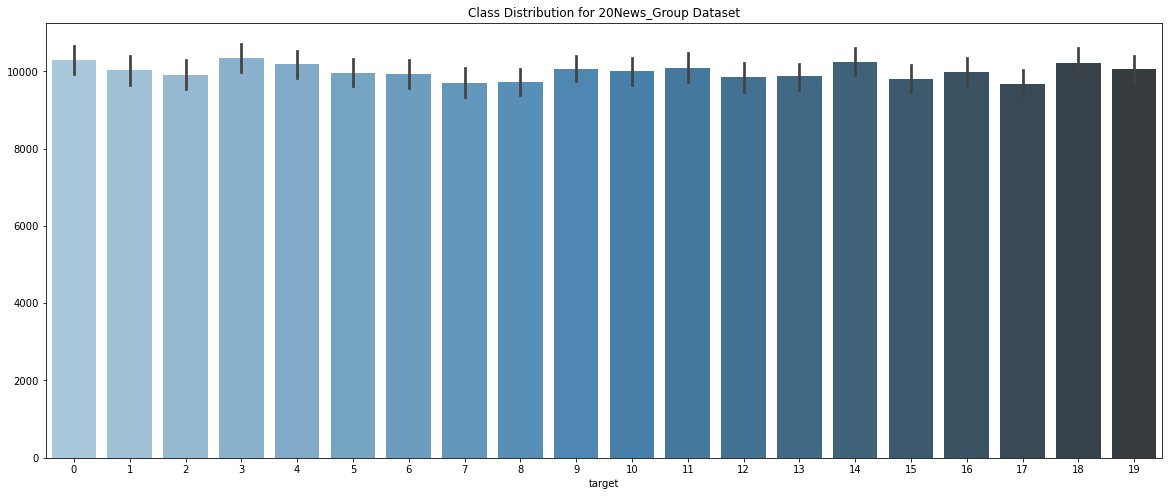

In [5]:
analysis.class_distribution(twenty_groups_df, "20News_Group Dataset")

The classes are approximately balanced. We'll first try to train the models without oversampling/undersampling. If we see some bias in the model, we'll use these techniques.

## length by category

count     19997.000000
mean       2306.992449
std        3912.980384
min         345.000000
25%        1139.000000
50%        1600.000000
75%        2321.000000
max      161040.000000
Name: length, dtype: float64


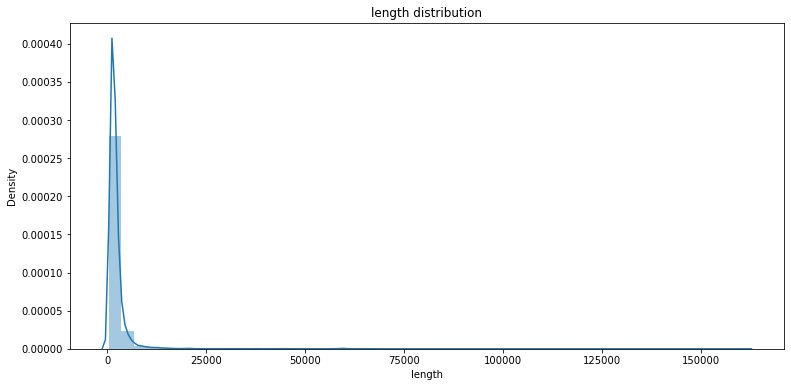

In [6]:
analysis.length_distribution(twenty_groups_df)

Plot does not seems to look good, so Let's remove from the 95% percentile onwards for better understanding.

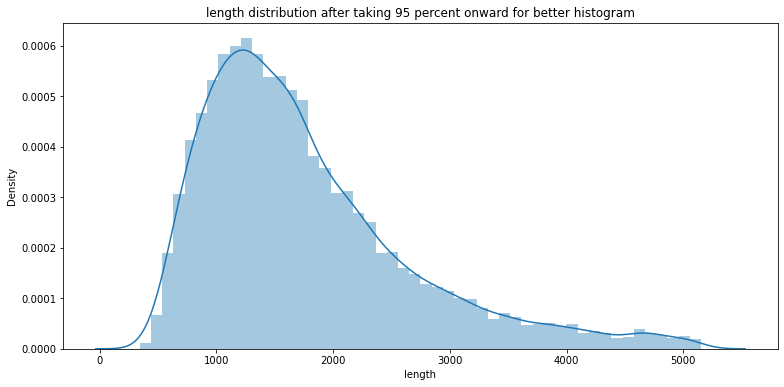

In [7]:
analysis.length_distribution_after_quantile(twenty_groups_df)

Now lets see an exemple of words Occurences.

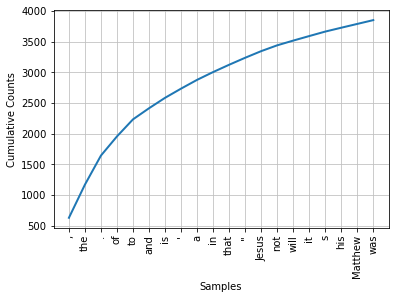

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [23]:
corpus_root = f"{twenty}alt.atheism/"
filelists = PlaintextCorpusReader(corpus_root, '.*')
wordslist = filelists.words('53519')
fdist = FreqDist(wordslist)
fdist.plot(20, cumulative=True)

Text(0, 0.5, 'Words Frequency')

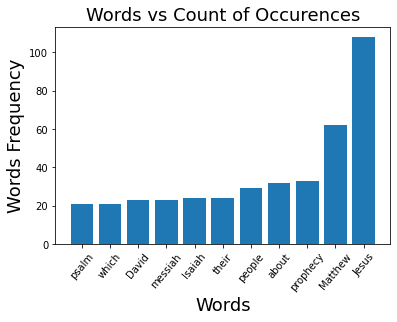

In [32]:
frequent_words = [[fdist[word], word] for word in set(wordslist) if len(word) > 4 and fdist[word] >= 20]
sorted_word_frequencies = {}
for item in sorted(frequent_words):
    sorted_word_frequencies[item[1]] = item[0]
    
plt.bar(range(len(sorted_word_frequencies)), list(sorted_word_frequencies.values()), align='center')
plt.xticks(range(len(sorted_word_frequencies)), list(sorted_word_frequencies.keys()), rotation=50)
plt.title("Words vs Count of Occurences", fontsize=18)
plt.xlabel("Words", fontsize=18)
plt.ylabel("Words Frequency", fontsize=18)

## boxplot

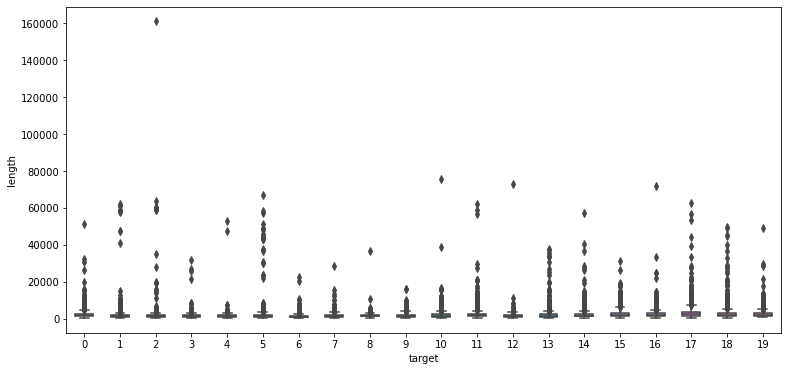

In [9]:
analysis.barplot(twenty_groups_df)

Now lets take down large documents

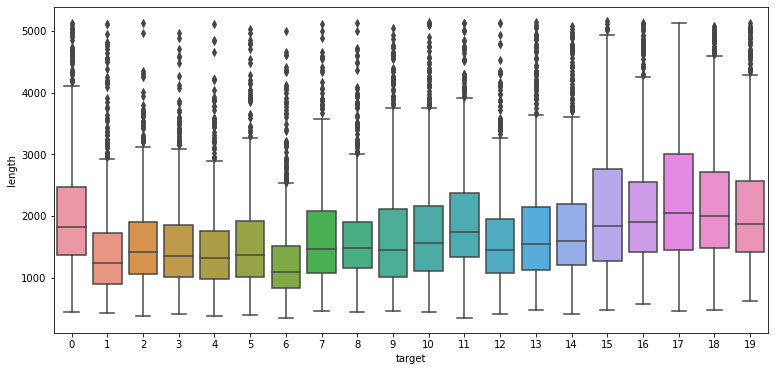

In [11]:
analysis.barplot_no_long_articles(twenty_groups_df)

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

## Movie Review Dataset

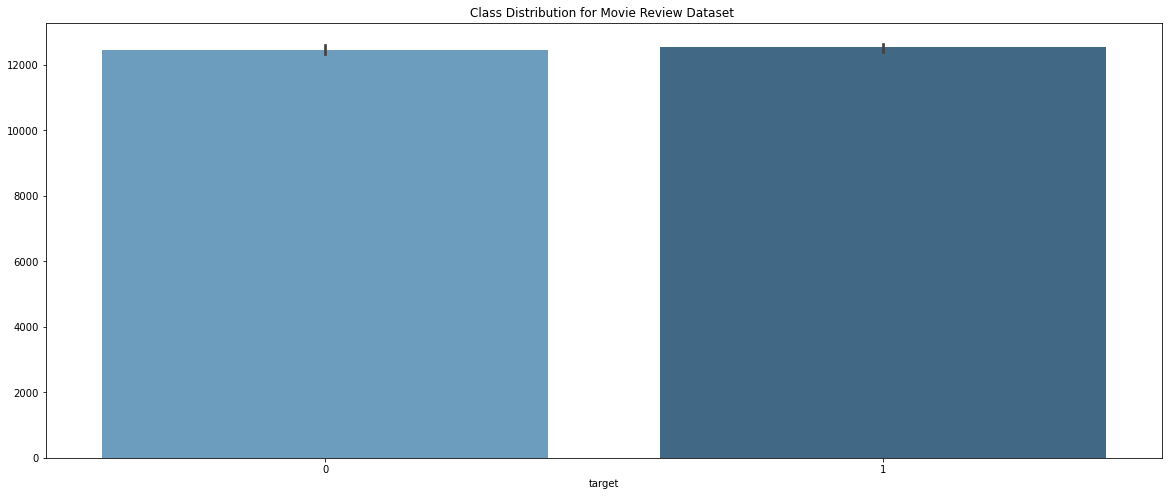

In [12]:
analysis.class_distribution(pos_neg_df, "Movie Review Dataset ")

The classes are balanced. with 12500 positive and 12500 negative review

count    25000.000000
mean      1325.312920
std       1003.444892
min         52.000000
25%        702.000000
50%        979.000000
75%       1614.000000
max      13704.000000
Name: length, dtype: float64


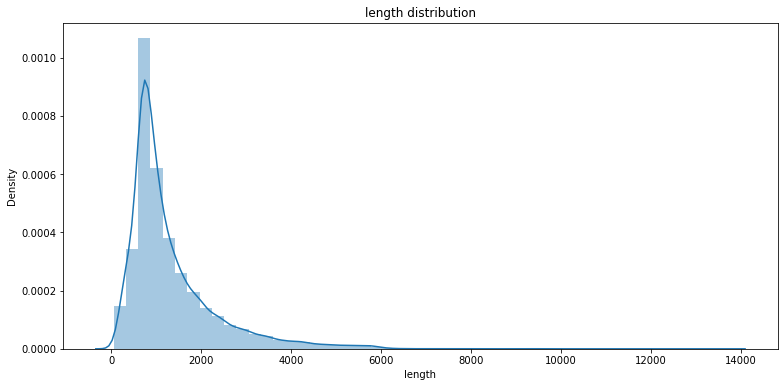

In [13]:
analysis.length_distribution(pos_neg_df)

using same technique by remove from the 95% percentile

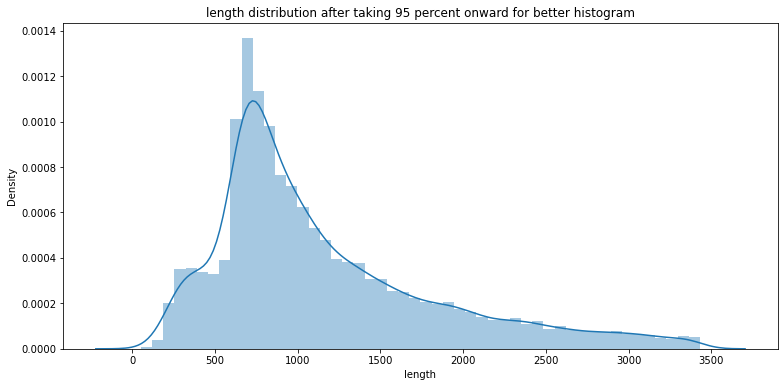

In [14]:
analysis.length_distribution_after_quantile(pos_neg_df)

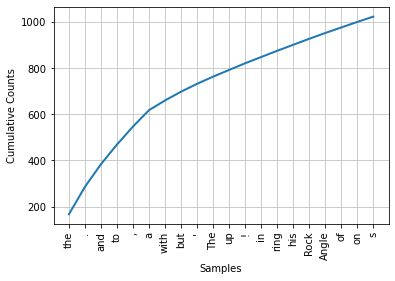

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [46]:
corpus_root = f"{pos_neg}pos/"
filelists = PlaintextCorpusReader(corpus_root, '.*')
wordslist = filelists.words('1175_9.txt')
fdist = FreqDist(wordslist)
fdist.plot(20, cumulative=True)

Text(0, 0.5, 'Words Frequency')

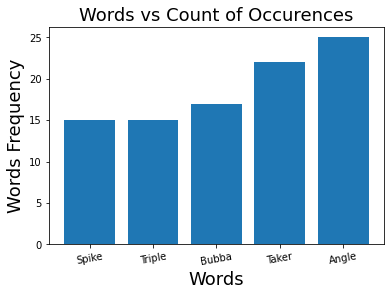

In [48]:
frequent_words = [[fdist[word], word] for word in set(wordslist) if len(word) > 4 and fdist[word] >= 15]
sorted_word_frequencies = {}
for item in sorted(frequent_words):
    sorted_word_frequencies[item[1]] = item[0]
    
plt.bar(range(len(sorted_word_frequencies)), list(sorted_word_frequencies.values()), align='center')
plt.xticks(range(len(sorted_word_frequencies)), list(sorted_word_frequencies.keys()), rotation=10)
plt.title("Words vs Count of Occurences", fontsize=18)
plt.xlabel("Words", fontsize=18)
plt.ylabel("Words Frequency", fontsize=18)

# boxplot

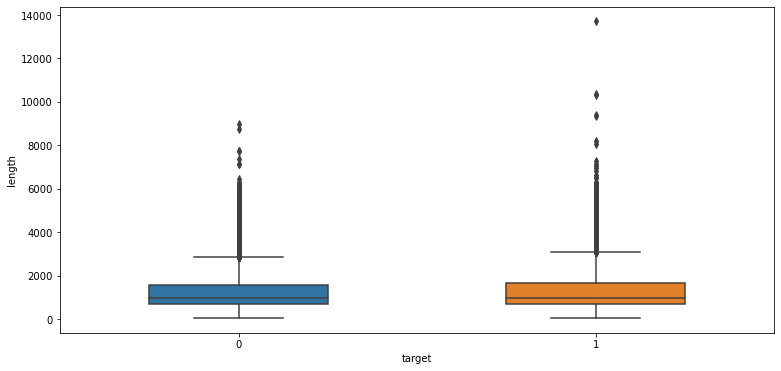

In [15]:
analysis.barplot(pos_neg_df)

Looks like there is a long reviews in positive then negative, to make it clear lets take them down

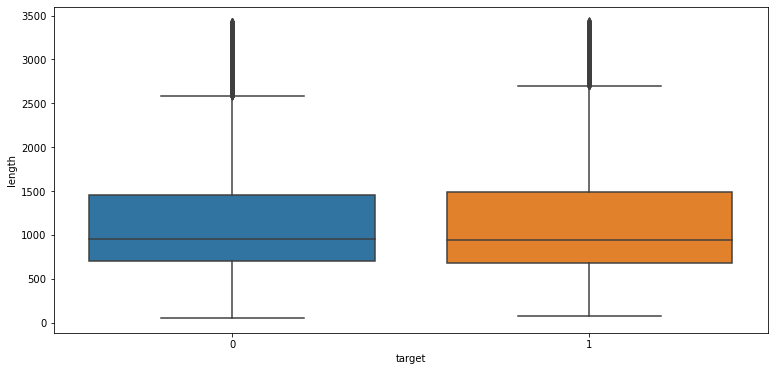

In [16]:
analysis.barplot_no_long_articles(pos_neg_df)

Now we see they are almost identical regarding review length.

# Step 3 - Text Preprocessing

In [4]:
## transform data to csv format
preprocessing.twenty_newsgroup_to_csv()
preprocessing.pos_neg_to_csv()

In [2]:
newsgroup = pd.read_csv('20_newsgroup.csv')
pos_neg = pd.read_csv('pos_neg.csv')

## 3.1. Special character cleaning
We can see the following special characters:

- \r
- \n
- \ before possessive pronouns (government's = government\'s)
- \ before possessive pronouns 2 (Yukos' = Yukos\')
- " when quoting text

In [12]:
df = preprocessing.scc(pos_neg)

## 3.2. Upcase/downcase

We'll downcase the texts because we want, for example, Football and football to be the same word.

In [13]:
df = preprocessing.lowercase(df)

## 3.3. Punctuation signs
Punctuation signs won't have any predicting power, so we'll just get rid of them.

In [14]:
df = preprocessing.punc(df)

## 3.4. Possessive pronouns

We'll also remove possessive pronoun terminations:

In [15]:
df = preprocessing.posses(df)

## 3.5. Stemming and Lemmatization

Lemmatization takes into consideration the morphological analysis of the words and returns words that do exist

In [9]:
# Download punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ouassimkiassa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ouassimkiassa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
df = preprocessing.lem(df)

## 3.6. Stop words

In [14]:
# Download the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ouassimkiassa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
df = preprocessing.stopword_removal(df)

In [18]:
df = preprocessing.final(df)

In [22]:
df

,text,text_parsed
0,"b""Zero Day leads you to think, even re-think w...",bzero day lead think even -think two boys/y...
1,b'Words can\'t describe how bad this movie is....,b'words \' describe bad movie \' explain ...
2,b'Everyone plays their part pretty well in thi...,b'everyone play part pretty well little nic...
3,b'There are a lot of highly talented filmmaker...,b' lot highly talented filmmakers/actors g...
4,b'I\'ve just had the evidence that confirmed m...,b'\' evidence confirm suspicions bunch ...
...,...,...
24995,b'089: Footlight Parade (1933) - released 9/30...,b'089 footlight parade (1933) - release 9/30/1...
24996,b'Deeply humorous yet honest comedy about a bu...,b'deeply humorous yet honest comedy bunch g...
24997,b'1st watched 2/28/2006 - 4 out of 10(Dir-Sydn...,b'1st watch 2/28/2006 - 4 10(dir-sydney poll...
24998,"b""I watch lots of scary movies (or at least th...",bi watch lot scary movies ( least try ) ...
